# Assignment 1


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
from keras.callbacks import ModelCheckpoint
import os, random
from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D,Conv2D,BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras import backend as K
import h5py
import operator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import tensorflow as tf
import json
import cv2
import os
import csv
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#mount drive
drive.mount('/content/gdrive/')

#create some directories (to do only once)

#create directories for dataset reorganization on train,val and test folders. each one contains two subdirectories: 0 and 1 (no tomato, tomato)
!mkdir /content/gdrive/My\ Drive/dataset
!mkdir /content/gdrive/My\ Drive/dataset/train
!mkdir /content/gdrive/My\ Drive/dataset/train/0
!mkdir /content/gdrive/My\ Drive/dataset/train/1
!mkdir /content/gdrive/My\ Drive/dataset/test
!mkdir /content/gdrive/My\ Drive/dataset/test/0
!mkdir /content/gdrive/My\ Drive/dataset/test/1
!mkdir /content/gdrive/My\ Drive/dataset/val
!mkdir /content/gdrive/My\ Drive/dataset/val/0
!mkdir /content/gdrive/My\ Drive/dataset/val/1

#create 2 directories to save the history for each assignment model
!mkdir /content/gdrive/My\ Drive/foodvisor_history #assignment 1


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
base_path = '/content/gdrive/My Drive/'
imgs_path = base_path+"assignment_imgs/"
dataset_path = base_path+"dataset/"
train_dir = dataset_path+"train/"
val_dir = dataset_path+"val/"

In [ ]:
#mobilenetv2 requires the image shape to be equal to 224
IMG_SHAPE = 224

As the entire dataset contains only few images with tomates, we have decided to take a equal number of images where the tomato appears or not. Otherwise, it may not enough for the model to learn the concept of tomato 

In [ ]:
class MyDataLoader():
    def __init__(self, base_path,imgs_path, annotation_dir,labels_dir,IMG_SHAPE):
        print("Loading data...")
        self.base_path = base_path
        self.imgs_path = imgs_path
        self.load_imgs()
        self.load_labels(labels_dir)
        self.load_annotations(annotation_dir)
        self.IMG_SHAPE = IMG_SHAPE
        
        print("Done")


    def getsize(self):
        return len(self.data)

    def load_imgs(self):
      imgs = []
      for img_path in os.listdir(self.imgs_path):
          imgs.append(img_path)
      self.images_ids = np.array(imgs)
      print("=> ID images loaded")

    def load_annotations(self,annotation_dir):
      #create a dictionary where the key is the image name and the key is the label (0: no tomato, 1: tomato)
      self.data={}
      self.data_complete_name={}
      self.img_annotations = json.loads(open(annotation_dir, "r").read())
      for key in self.img_annotations:
        #get the identified classes on the image (1 tomate, 0 otherwise)
        img_classes=[]
        for element in self.img_annotations[key]:
          id = element['id']
          img_classes.append(int((self.labels[id])))
        y = np.max(np.array(img_classes))
        self.data[key.split(".")[0]] = y 
        self.data_complete_name[key] = y 
        
      print("=> Images annotations loaded")
      
      self.data = dict( sorted(self.data.items(), key=operator.itemgetter(1)))
      a = np.array(list(self.data.values()))
      unique, counts = np.unique(a, return_counts=True)

      stats_data = dict(zip(unique, counts))
      self.nb_tomate_dataset = stats_data[1]
      self.nb_no_tomate_dataset = stats_data[0]

    def load_labels(self,labels_dir):
      data = pd.read_csv(labels_dir)
      df = pd.DataFrame(data, columns= ['labelling_id','labelling_name_fr','labelling_name_en'])
      
      #convert labels name_fr to 0 if no tomatoe 1 otherwise
      df['labelling_name_fr'] = df['labelling_name_fr'].str.contains('tomates|Tomates|tomate|Tomate').astype(int)

      #create a dictionary where keys are labelling id and values are labelling names in french
      data = np.array(df.to_dict('split')['data'])
      self.labelling_ids = data[:,0]
      self.labelling_name_fr =data[:,1].astype(int)

      self.labels=dict()
      for i in range(data.shape[0]):
          self.labels[self.labelling_ids[i]] = self.labelling_name_fr[i]
      print("=> Labels loaded")

    def reorganize_data(self,label):
      #create 2 folders train and val, in each folder there are 2 subfolders, one with images with tomatoes and the other without tomatoes
      num_examples = self.nb_tomate_dataset
      num_train_examples = int(num_examples * 0.8)
      print("num_train_examples",num_train_examples)
      num_val_examples =  int(num_examples * 0.2)
      print("num_val_examples",num_val_examples)

      counter_train = 0
      counter_val = 0
      counter_test = 0
      for idx in self.data_complete_name.keys():
        y = self.data_complete_name[idx]
        if counter_train < num_train_examples and y == label:
          x = cv2.imread(self.imgs_path+idx, cv2.IMREAD_COLOR)
          x = cv2.resize(x,(self.IMG_SHAPE,self.IMG_SHAPE))
          cv2.imwrite(self.base_path+"dataset/train/"+str(y)+"/"+idx.split(".")[0]+".png",x)
          counter_train = counter_train + 1
          continue

        if counter_val < num_val_examples and y == label:
          x = cv2.imread(self.imgs_path+idx, cv2.IMREAD_COLOR)
          x = cv2.resize(x,(self.IMG_SHAPE,self.IMG_SHAPE))
          cv2.imwrite(self.base_path+"dataset/val/"+str(y)+"/"+idx.split(".")[0]+".png",x)
          counter_val = counter_val + 1
          continue





In [ ]:
#crate the dataloader
dataloader = MyDataLoader(base_path,imgs_path,base_path+"img_annotations.json",base_path+'label_mapping.csv',IMG_SHAPE)

Loading data...
=> ID images loaded
=> Labels loaded
=> Images annotations loaded
Done


In [ ]:
#to execute only once, it will create in MyDrive the new dataset structure
dataloader.reorganize_data(0)
dataloader.reorganize_data(1)

In [ ]:
#print some stats on the dataset
num_train_0 = len(os.listdir(train_dir+"/0/"))
num_train_1 = len(os.listdir(train_dir+"/1/"))
num_val_0 = len(os.listdir(val_dir+"/0/"))
num_val_1 = len(os.listdir(val_dir+"/1/"))

print('Number of images without tomatoe in train folder is: {}'.format(num_train_0))
print('Number of images with tomatoe in train folder is: {}'.format(num_train_1))

print('Number of images without tomatoe in val folder is: {}'.format(num_val_0))
print('Number of images with tomatoe in val folder is: {}'.format(num_val_1))

Number of images without tomatoe in train folder is: 439
Number of images with tomatoe in train folder is: 439
Number of images without tomatoe in val folder is: 109
Number of images with tomatoe in val folder is: 109


In [ ]:
#generate and load data for train and validation processes
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      zoom_range=0.2,
      horizontal_flip=True,
      )

train_data_gen = image_gen_train.flow_from_directory(batch_size=439*2,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=109*2,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')


#convert DirectoryIterator to numpy array
X_train, Y_train = train_data_gen.next()
print("X train shape",X_train.shape)
print("Y train shape",Y_train.shape)
print()

X_val, Y_val = val_data_gen.next()
X_val.shape
print("X val shape",X_val.shape)
print("Y val shape",Y_val.shape)


Found 878 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
X train shape (878, 224, 224, 3)
Y train shape (878,)

X val shape (218, 224, 224, 3)
Y val shape (218,)


# Dataset exploration
Before begining the learning process, lets discover the dataset

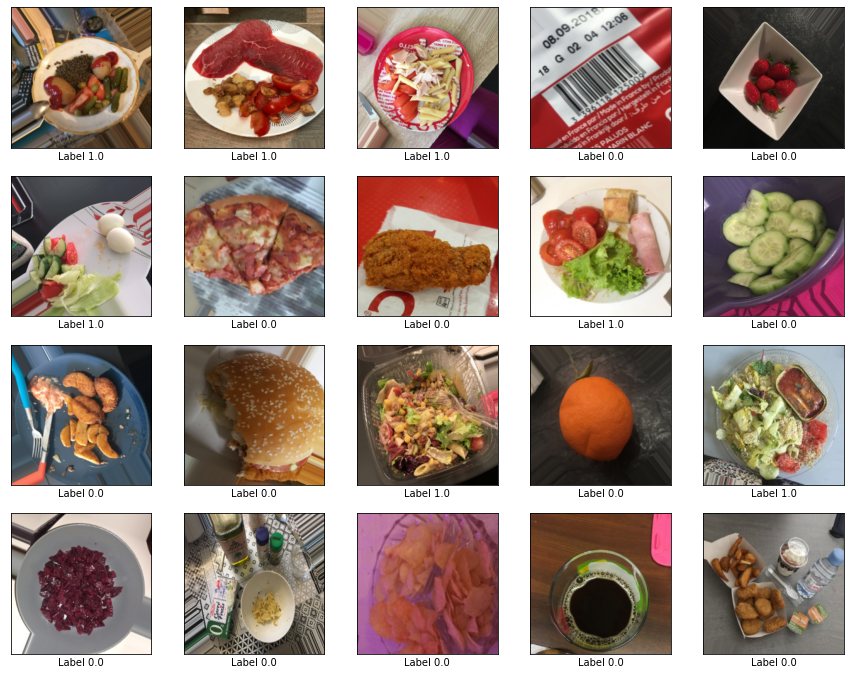

In [ ]:
#label = 0 : no tomato and label = 1 : tomato
plt.figure(figsize=(15,15))
i = 0
for i in range(20):
    image = X_train[i]
    y =  Y_train[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel("Label "+str(y))
    i += 1
plt.show()

# Transfer Learning with MobileNet v2
We use MobileNetV2 for transfer learning. The new dense layer contains only 1 output. Because it is a binary problem

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_SHAPE, IMG_SHAPE, 3))
#we have to set the feature extractor to false, in oorder not to train it again 
feature_extractor.trainable = False

In [ ]:
#model creation
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### Model training

In [ ]:
#Compile the model
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'])

#set the number of epochs
EPOCHS = 6

#instatiate the checkpoint as callback
checkpoint_path = "cp-{epoch:04d}.cpkt"
checkpoint_filepath = os.path.join(base_path+"foodvisor_history/",checkpoint_path)
checkpoint =  ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_acc',
    verbose = 1,
    mode = 'max',
    save_freq='epoch',
    save_best_only=False)

#launch the train process
history = model.fit(x=X_train, y = Y_train,epochs=EPOCHS,validation_data=(X_val,Y_val), callbacks=[checkpoint])

Epoch 1/6
27/28 [===========================>..] - ETA: 0s - loss: 0.7569 - accuracy: 0.5162
Epoch 00001: saving model to /content/gdrive/My Drive/foodvisor_history/cp-0001.cpkt
28/28 [==============================] - 6s 230ms/step - loss: 0.7543 - accuracy: 0.5182 - val_loss: 0.5723 - val_accuracy: 0.7018
Epoch 2/6
28/28 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.7449
Epoch 00002: saving model to /content/gdrive/My Drive/foodvisor_history/cp-0002.cpkt
28/28 [==============================] - 6s 201ms/step - loss: 0.5244 - accuracy: 0.7449 - val_loss: 0.5009 - val_accuracy: 0.7385
Epoch 3/6
28/28 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7722
Epoch 00003: saving model to /content/gdrive/My Drive/foodvisor_history/cp-0003.cpkt
28/28 [==============================] - 6s 219ms/step - loss: 0.4683 - accuracy: 0.7722 - val_loss: 0.4812 - val_accuracy: 0.7569
Epoch 4/6
27/28 [===========================>..] - ETA: 0s - loss: 0.4280

# Plot Training and Validation loss & accuracy

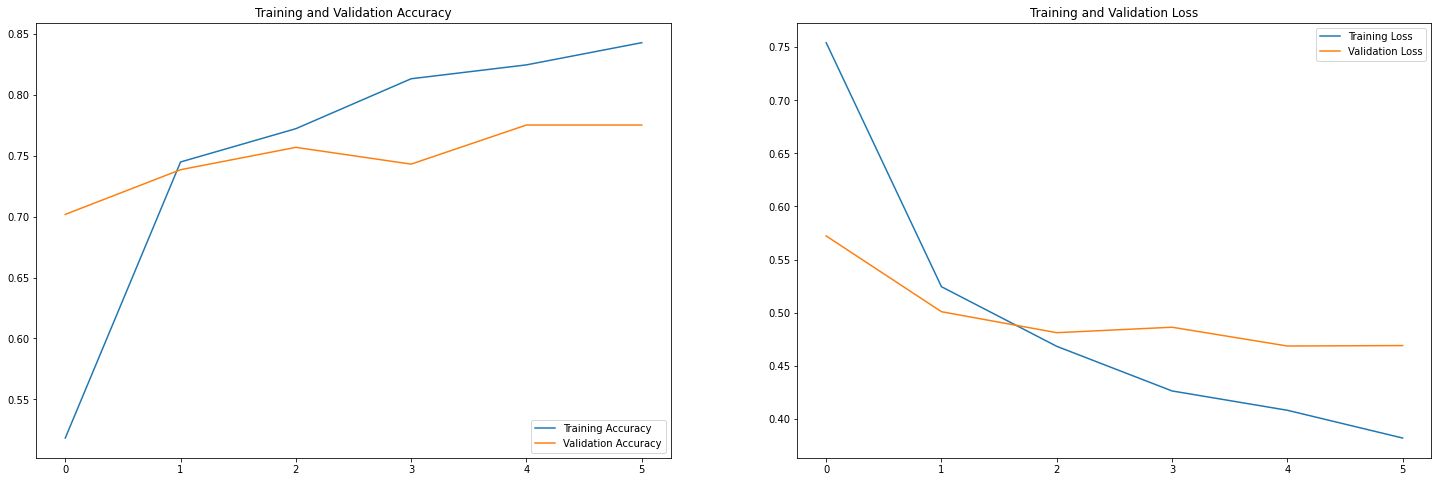

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save model and weights

In [ ]:
model.save(base_path+"foodvisor_my_model")
model.save_weights(os.path.join(base_path,'foodvisor_my_model_weights.h5'))

# Predict some images from the validation dataset

Image  0 probability of tomato:  0.09673887
Image  1 probability of tomato:  0.50623846
Image  2 probability of tomato:  0.06815041
Image  3 probability of tomato:  0.62969226
Image  4 probability of tomato:  0.6137578
Image  5 probability of tomato:  0.125
Image  6 probability of tomato:  0.6709867
Image  7 probability of tomato:  0.60522455
Image  8 probability of tomato:  0.2526139
Image  9 probability of tomato:  0.15984629
Image  10 probability of tomato:  0.6411883
Image  11 probability of tomato:  0.09345812
Image  12 probability of tomato:  0.7485992
Image  13 probability of tomato:  0.10181443
Image  14 probability of tomato:  0.5075366
Image  15 probability of tomato:  0.6844249
Image  16 probability of tomato:  0.7613893
Image  17 probability of tomato:  0.7380586
Image  18 probability of tomato:  0.2314734
Image  19 probability of tomato:  0.923122


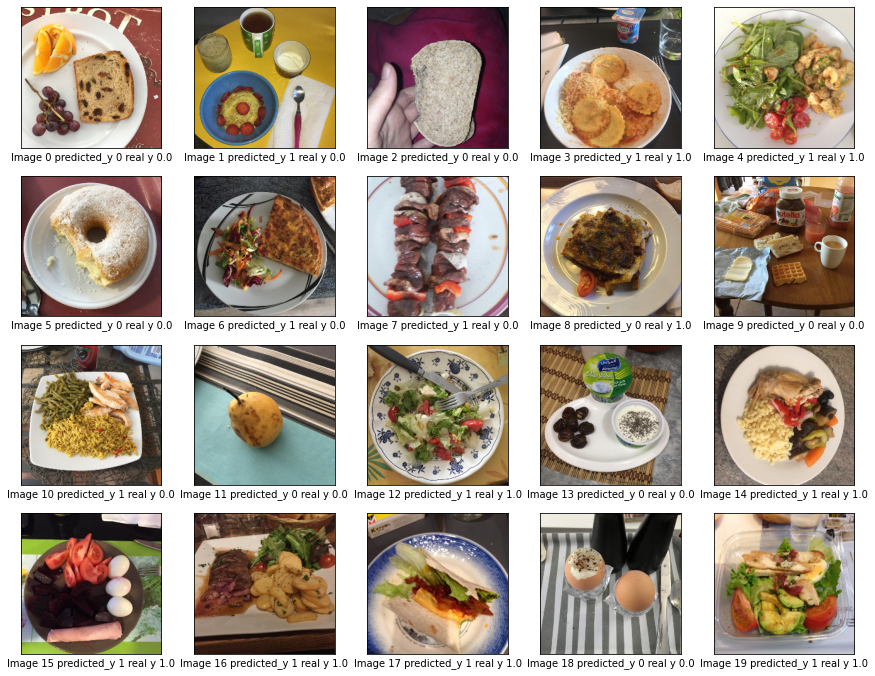

In [ ]:
plt.figure(figsize=(15,15))
i = 0
for i in range(20):
    image = np.array([np.transpose(X_val[i], (0,1,2))])
    
    predicted_y = model.predict(image)[0][0]
    print("Image ",i,"probability of tomato: ", predicted_y)
    if predicted_y > 0.5:
      predicted_y = 1
    else:
      predicted_y = 0
    y =  Y_val[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[i])
    plt.xlabel("Image "+ str(i)+" predicted_y "+str(predicted_y)+ " real y "+str(y))
    i += 1
plt.show()

We can see that on the image 7, the model predicts the presence of tomato. Nevertheless, it is a red bell pepper, Which still similar to the shape of tomato.
Also, on the3 and 10 images, maybe the model detect some red color on the image and think that it is a sign for the presence of tomato.


# Create a function which predicts whether a tomato exists on the image or not

In [ ]:
def has_tomatoes(image_path):
  x = cv2.imread(image_path, cv2.IMREAD_COLOR)
  x = cv2.resize(x,(224,224))
  image = np.array([np.transpose(x, (0,1,2))])
  predicted_y = model.predict(image)[0][0]
  print(predicted_y)
  if predicted_y > 0.5:
    return True
  else:
    return False

In [ ]:
image_path = imgs_path+"ffef5cb12b8e2ac5ac5fa7563cd2f5ed.jpeg"
has_tomatoes(image_path)

0.011114668


False